# **AM 207**: Homework 2

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday March 3rd, 2015**

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW2.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW2.tar.gz or AM207_YOURNAME_HW2.zip


### Have Fun!
_ _ _ _ _

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy
import scipy.stats as stats
import pandas as pd
import pymc as pm

import re
import numpy as np


/Users/xdai/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Problem 1: Geweke Convergence Test

In the lecture we have seen the Geweke test as one option to test for convergence of our metropolis hastings chain. Describe in your own words how the Geweke test works and its limitations. 

We provide you with the following code for the Geweke test. Write comments for the marked lines and any lines you think would be good to explain in addition. 

Write a short explanation of what the `rhot` function does and why it is necessary. 

### Solution:
What is Geweke test?

The Geweke test is a quantity way to check the convergence of MCMC. The formula is to find two chain sample and divide them and normalize with the standard deviation. If the output of the function is below than 2, it is considered as convergence and vice versa. 

The fomula mentioned above:

$$z = \frac{\theta_a-\theta_b}{\sqrt{var(\theta_a)+var(\theta_b)}}$$


Auto-correction, what the $rho$ function does and why it is necessary?

Metropolis Hasting is a markov chain and therefore by construction is not iid and therefore will exhibit high autocorrelation. To reduce the autocorrelation, people would normally use "thinning". Here, rhot function is to calculates its autocorrelation and to factor the autocorrelation out later on. 



In [24]:
# rhot function here is to calculate autocorrection the front and 't' end part of chain. 
def rhot(x, t):
    n = len(x)
    return np.corrcoef(x[0:(n-t)], x[t:n])[0,1]

# Here we define the Geweke function
def Geweke(trace, intervals, length):
    nsl=length
    #get the step size, the two portions will move toward 
    #the end by this step size
    jump = int(0.9*len(trace)/(2*intervals))
    #First portion of chain to be used in this diagnostic
    #later on, we will jump the first portion, as it may 
    #contain burn-in
    first = 0.1*len(trace)
    
    z =np.empty(intervals)
    #loop all sub-chains to be analyzed
    for k in np.arange(0, intervals):
        #choose the early interval;every time move one jump step
        baga = np.int(first+k*jump)
        #start from the 50% of chain; every time move one jump step
        bagb = len(trace)/2 + k*jump
        
        #store those two interval values into variables
        sub_trace_a = trace[baga:baga+nsl]
        sub_trace_b = trace[bagb:bagb+nsl]
        
        #get the mean values of those two portions 
        theta_a = np.mean(sub_trace_a)
        theta_b = np.mean(sub_trace_b)
        rho_a, rho_b = 1.0, 1.0
        # loop through the chain with 10% step size 
        for i in xrange(int(0.1*nsl)):
            # Here calcualte autocorrelation and add each step size's result
            rho_a += 2*rhot(sub_trace_a, i+1)
            rho_b += 2*rhot(sub_trace_b, i+1)
            
        # 
        var_a  = np.var(sub_trace_a)*rho_a/length
        var_b  = np.var(sub_trace_b)*rho_b/length
        
        #use the formula above to calculate z score
        z[k] = (theta_a-theta_b)/np.sqrt( var_a + var_b)
    
    return z


# Problem 2: Message Response Times

The file `hangout_chat_data.csv` contains the response times of your friend Mark to google hangout chat messages in seconds. Use a method of your choice to read the file into a data frame or a numpy array. Your goal for this problem is to model Mark's chat response time distribution in a Bayesian framework. 

The description of the data sounds like a Poisson distribution is a good choice for our likelihood. We have messages arriving independently of each other, and instead of the arrival time we consider the time it took Mark to respond to the messages. 

* Load and describe the data by plotting a histogram of the response times. 
* Derive and compute the maximum likelihood solution for a Poisson distribution.
* Compare this to the Bayesian solution with a prior of your choice and using your own implementation of Metropolis Hastings to sample from the posterior. Make sure to describe why you chose this prior, as well as the specifics of your Metropolis Hastings implementation. 

* Analyze your sampling using traceplots and convergence tests. You can use the Geweke implementation given above. 
* Compare your solution to a solution using the MCMC class in pymc and write a brief discussion. Which parameters does your implementation need that the pymc implementation can do without? How do the traceplots compare? 

* Check your ML solution and the Bayesian solution against the data. If you know how you can use the posterior predictive for the Bayesian solution, otherwise you can use the MAP estimate or the expectation value of the posterior and compare that distribution to the data histogram. 

* Was our model a good choice for this problem? If yes great, if not, come up with a different Bayesian model that is better capable of capturing the data and show that it works better. 


    0
0  12
1  38
2  12
3  23
4  11


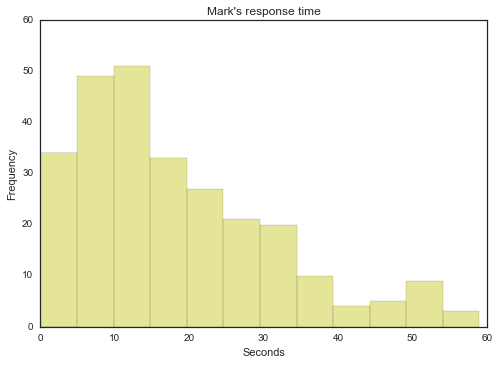

In [2]:
#load the data and plot the histogram of the response time
respdf = pd.read_csv("hangout_chat_data.csv",header=None)
print respdf.head()
ax = sns.distplot(respdf,color="y",kde=False)
ax.set(xlabel='Seconds', ylabel='Frequency',title="Mark's response time")

### Describe the data

The plot above shows my data has a higher chance of being a Poisson distribution.

### Derive the MLE for Poisson distribution

given $x_1, x_2 ... x_m$, We have 
$$P(x_i) = \frac{\exp^{-\lambda}* \lambda^{x_i}}{x_i!}$$
the product rule:
$$\prod{\frac{\exp{-\lambda}* \lambda^{x_i}}{x_i!}}$$
Take the log, derivative and get:
$$\frac{\partial l}{\partial \lambda} = -N + \sum_i{X_i\frac{1}{\lambda}} = 0$$
$$\lambda N = \sum X_i$$
Finally:
$$\lambda = \frac{\sum{X_i}}{N}$$


In [3]:
#Compute my likelihood function
array_like = respdf[0].values
lam = np.sum(array_like)/len(array_like)
print "The MLE solution for my parameter(lambda) is:",lam

The MLE solution for my parameter(lambda) is: 18


### Metropolis Algorithm and the choice of Prior

Since here we have a Poisson likelihood, I could either choose the conjugate prior of Gamma distribution or any other belief I have without considering data given to me. As such, I chose Jeffers Prior in this part. Many students suggest to choose Gamma Prior, based on the assumption that likelihood is Poisson. However, by doing that, we actually contaminate the purity of Prior. 

#### Jeffers Prior
From a practical and mathematical standpoint, a valid reason to use this non-informative prior instead of others, like the ones obtained through a limit in conjugate families of distributions, is that it is not dependent upon the set of parameter variables that is chosen to describe parameter space. However, many statistians also believe that using Jefferys Prior breaks the likelihood principal. It is beyond the scope of this description to discuss this here. Also, later on, we will see that even Poisson is not a good guess of our likelihood

#### Metropolis Algorithm

Metropolis algorithm is among the top ten most used algorithms in science and engineering in the last twenty years. Metropolis algorithm is one of the algorithms in a large class of stochastic algorithms known as Markov chain Monte Carlo (MCMC). These algorithms are often used in statistics, econometrics, physics and computing science, etc and have proven to make significant contribution to many scientific fields. Especially in high-dimensional problems, such as computing the volume of a convex body in d-dimensions, for which MCMC simulation is the only known general approach for providing a solution within a reasonable time (polynomial in d).

In this homework, I used the MH method to do MCMC. The basic procedual of MH algorithm is stated as follow:

Assume the current state $x^i$, and I am heading to the next state $x^{i+1}->x^i$, 
* compute $\frac{S(x^*)}{S(x^i)}$
* find $a_{i*} = min(\frac{S(x^*)}{S(X^i)},1)$
* if u < a_{ix), $x^{i+1} = x^*$,
* otherwise, $x^{i+1} = x^i$

In [12]:
from scipy.stats import poisson
rnorm = np.random.normal
runif = np.random.rand

#Here is how I should calculate my posterior
def calc_posterior(lam, k=array_like):
    # Calculate joint posterior
    p = np.sum(np.log(poisson.pmf(k,lam)) + np.log(1/np.sqrt(lam)))
    return p

In [13]:
#################################################################
# function to sample using Metropolis 
# (assumes proposal distribution is symmetric)
# 
# n_iterations:  number of iterations
# initial_values: multidimensional start position for our chain
# prop_std: standard deviation for Gaussian proposal distribution 
##################################################################

def metropolis(n_iterations,initial_values,prop_std,doPrint=True):
    #np.random.seed(seed=1)
    n_params = len(initial_values)

    # Initial proposal standard deviations
    # generates a list of length n_params
    #prop_sd = [prop_std]*n_params
    prop_sd = prop_std

    # Initialize trace for parameters
    trace = np.empty(n_iterations+1)

    # Set initial values
    trace[0] = initial_values

    # Calculate joint posterior for initial values
    # the * assigns the arguments of the function according to the list elements
    current_prob = calc_posterior(trace[0])

    # Initialize acceptance counts
    # We can use this to tune our step size
    accepted = 0

    for i in range(n_iterations):

        if not i%10000 and doPrint: 
            print 'Iterations left: ', n_iterations-i

        # Grab current parameter values
        current_params = trace[i]

        # proposed new value
        theta = rnorm(current_params, 1)
        
        # Calculate posterior with proposed value
        proposed_prob = calc_posterior(theta)

        # Log-acceptance rate
        alpha = proposed_prob - current_prob

        # Sample a uniform random variate
        u = np.log(runif())

        # Test proposed value
        if (u) < alpha:
            # Accept
            trace[i+1] = theta
            current_prob = proposed_prob
            accepted += 1
        else:
            # Stay put
            trace[i+1] = trace[i]

    # return our samples and the number of accepted steps
    return trace, accepted

In [14]:
n_iter = 500
acc_ratios = []
for i in range(100):
    start_lambda = np.random.uniform(1,20,1) #just randomly generate a lambda(0-20)
    trace, acc = metropolis(n_iter, start_lambda,[1],doPrint=False)
    acc_ratios.append(acc/np.double(n_iter))

print "Acceptance rate:", np.mean(acc_ratios)

Acceptance rate: 0.31036


#### Analysis

As professor mentioned during the class, the accpetance rate is controlled under 30%

In [15]:
n_iter = 100000
trace, acc = metropolis(n_iter, (start_lambda),[1])
print acc/np.double(n_iter)

Iterations left:  100000
Iterations left:  90000
Iterations left:  80000
Iterations left:  70000
Iterations left:  60000
Iterations left:  50000
Iterations left:  40000
Iterations left:  30000
Iterations left:  20000
Iterations left:  10000
0.30465


In [16]:
print trace.shape

(100001,)


In [17]:
burnin = 10000    # MY BURN IN 
# throw away the burnin samples
alpha = trace[burnin:];

 (16, 20),

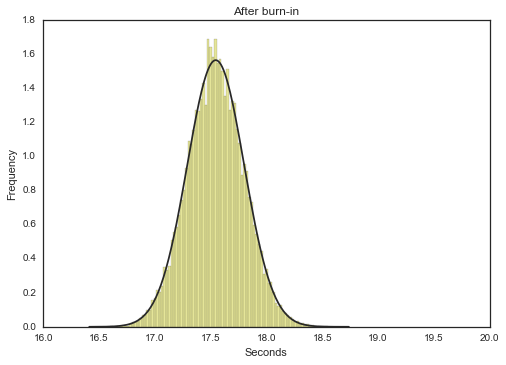

In [18]:
from scipy.stats import norm
ax = sns.distplot(alpha,color="y",kde=False,bins=100,fit=norm)
ax.set(xlabel='Seconds', ylabel='Frequency',title="After burn-in",xlim=[16,20])

<function matplotlib.pyplot.show>

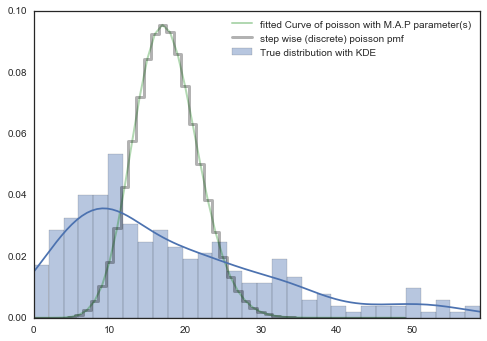

In [19]:
x = np.arange(0,50)
dist = scipy.stats.poisson(np.mean(alpha))

plt.plot(x, dist.pmf(x), color='g',
             alpha = 0.3, linewidth = 2, label = "fitted Curve of poisson with M.A.P parameter(s)")
plt.plot(x, dist.pmf(x), color = 'black', linestyle='steps-mid',alpha = 0.3,linewidth = 3,\
         label = "step wise (discrete) poisson pmf")
sns.distplot(array_like,norm_hist=  True,bins  = 30, label = "True distribution with KDE")
plt.xlim(0,max(array_like))
plt.ylim(0,0.1)
plt.legend()
plt.show

### Analysis

From the plot above, I see that our fitted curve of Poisson likelihood (with MAP parameters) doesn't match to the original distribution. I decided to check the convergence first, then maybe change another likelihood assumption.

### Convergence and Geweke Test

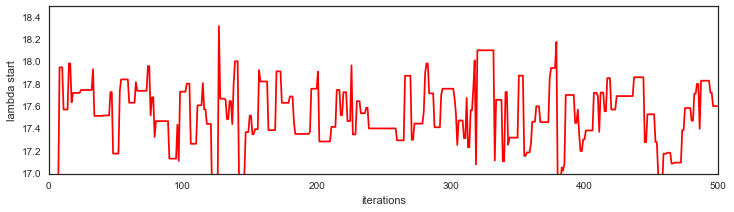

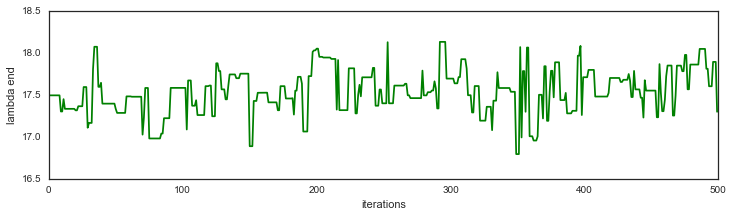

In [20]:
# Use Geweke test to check the convergence
plt.figure(figsize=[12,3])
burnin = 500    # MY BURN IN 
# throw away the burnin samples
alpha = trace[burnin:];
# trace plot for alpha during burnin
plt.plot(trace[:burnin],c='r')
plt.ylim(17,18.5)
plt.xlabel("iterations")
plt.ylabel("lambda start")

# trace plot for alpha at the end 
# where we hopefully converged
plt.figure(figsize=[12,3])
plt.plot(alpha[-burnin:],c='g')
plt.ylim(16.5,18.5)
plt.xlabel("iterations")
plt.ylabel("lambda end")


Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500


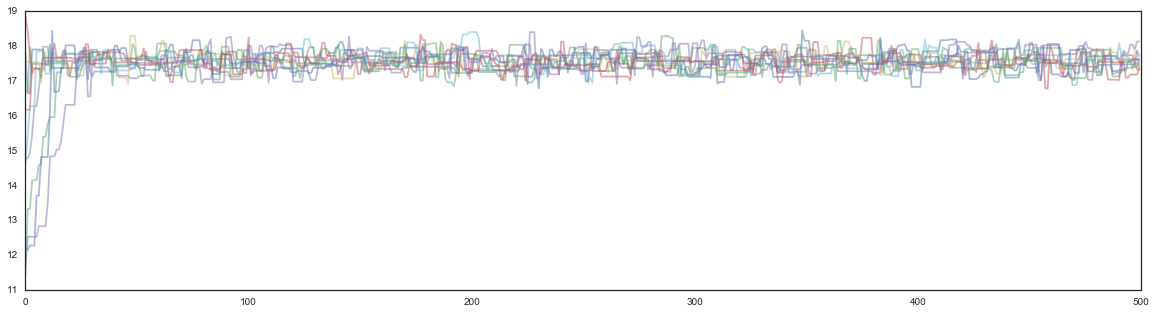

In [21]:
plt.figure(figsize=[20,5])

n_iter = 500
for i in range(10):
    start_alpha = np.random.uniform(10,20,1)
    trace, acc = metropolis(n_iter, start_alpha, 1) 
    plt.plot(trace[-500:], alpha=0.5)

Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500


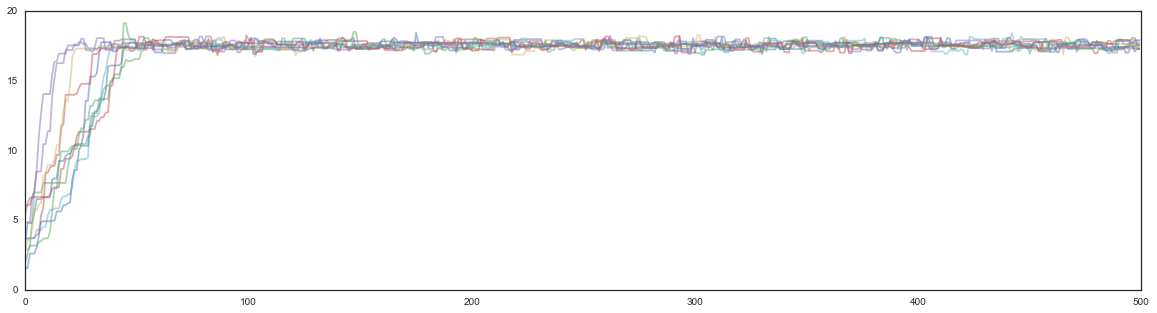

In [22]:
plt.figure(figsize=[20,5])

n_iter = 500
for i in range(10):
    start_alpha = np.random.uniform(1,5,1)
    trace, acc = metropolis(n_iter, start_alpha, 1) 
    plt.plot(trace[-500:], alpha=0.5)

(-4, 4)

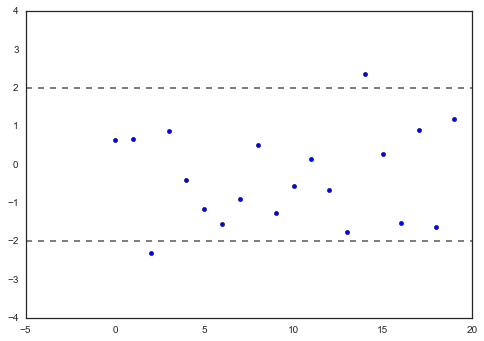

In [25]:
geweke_scores=Geweke(alpha[burnin:], intervals=20, length=2000)
plt.scatter(np.arange(20),geweke_scores)
plt.axhline(2, color='grey',lw=2,ls='dashed')
plt.axhline(-2, color='grey',lw=2,ls='dashed')
plt.ylim(-4,4)

#### Analysis
Judged by all plots shown above, I could make a holistic and concrete conclution that my MH converged in the end. Regardless of my starting point, the chain converged(slower or faster). In the Geweke's test, the majority points fall into the region of -2 to 2. As such, my MH converges.


### Foray into Pymc

In [26]:
# call MCMC using Poisson distribution and Jeffery's prior

#Define a function to take the response time of Marc, and the number of samples
# define the lambda value
samples=100000
lam = pm.Uniform("lam", 1., 20.)
@pm.deterministic 
def rate(lam = lam):
    return 1/np.sqrt(lam)
likelihood = pm.Poisson("observation", mu=lam, value=array_like, observed=True)
#Create the Bayesian model for pymc
model = pm.Model([lam, rate, likelihood])
mcmc = pm.MCMC(model)
#Ask pymc to run the sampler, specifying the burn in to be discarded
result = mcmc.sample(iter=samples, burn=samples / 4)


 [-----------------100%-----------------] 100000 of 100000 complete in 5.9 sec

In [27]:
mcmc.summary()


lam:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	18.044           0.26             0.002          [ 17.552  18.565]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	17.54            17.867          18.045         18.219        18.555
	

rate:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.235            0.002            0.0              [ 0.232  0.239]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.232            0.234           0.235          0.237         0.239
	


Plotting lam
Plotting rate


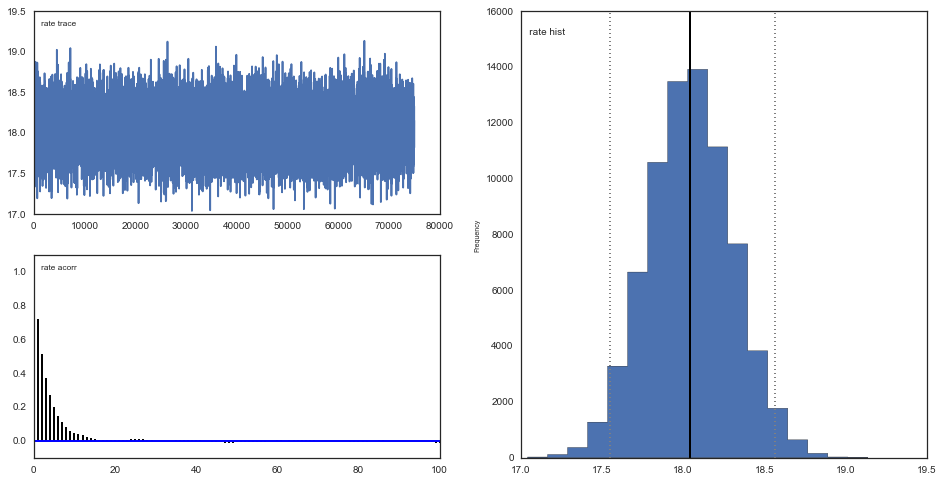

In [28]:
#Examine the sampling procedure
fig = plt.figure(figsize=(16,8))
pm.Matplot.plot(mcmc, new=False)

The MAP value I got is: 18.0414094411


<function matplotlib.pyplot.show>

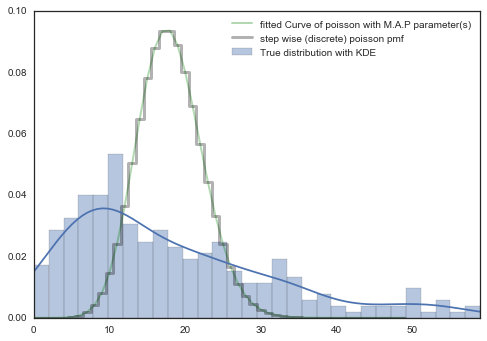

In [29]:
# Now calculate MAP
new_model = pm.MAP(model)
new_model.fit()
print "The MAP value I got is:",lam.value
x = np.arange(0,50)
dist = scipy.stats.poisson(np.mean(lam.value))

plt.plot(x, dist.pmf(x), color='g',
             alpha = 0.3, linewidth = 2, label = "fitted Curve of poisson with M.A.P parameter(s)")
plt.plot(x, dist.pmf(x), color = 'black', linestyle='steps-mid',alpha = 0.3,linewidth = 3,\
         label = "step wise (discrete) poisson pmf")
sns.distplot(array_like,norm_hist=  True,bins  = 30, label = "True distribution with KDE")
plt.xlim(0,max(array_like))
plt.ylim(0,0.1)
plt.legend()
plt.show

### Analysis:
My Pymc result validated my previous Metropolis Hasting Algorithm result. As such, it is highly likely that Verena suggests the wrong likelihood at first. 

### Foray into Negative Binomial Distribution

With the help from TFs, I decided to try negative binomial distribution.

In [32]:
alpha=pm.Uniform("alpha",0,100)
mu = pm.Uniform('mu',0,10)
likelihood=pm.NegativeBinomial("likelihood",alpha,mu,value = array_like, observed = True)

mcmc_model=pm.Model([alpha,mu,likelihood])
mcmc=pm.MCMC(mcmc_model)
mcmc.sample(iter=100000, burn=0)

 [-----------------100%-----------------] 100000 of 100000 complete in 19.4 sec

Plotting alpha
Plotting mu


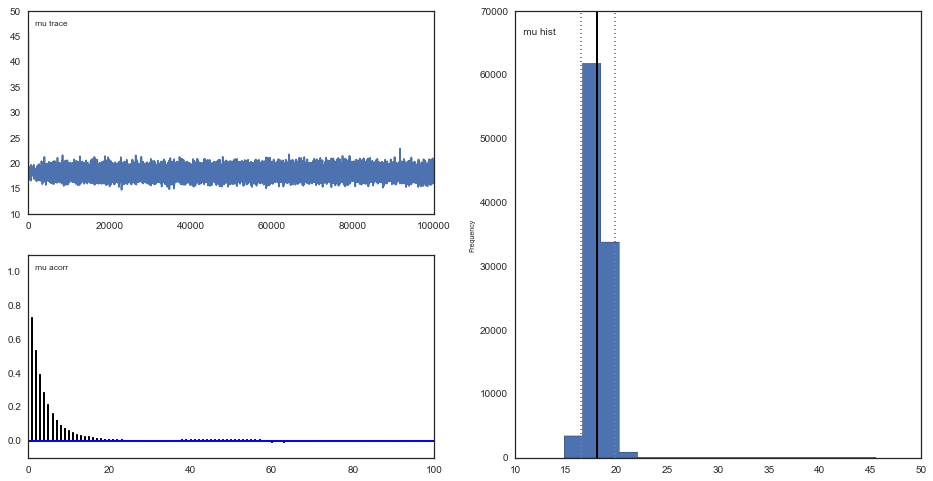

In [33]:
#Examine the sampling procedure
fig = plt.figure(figsize=(16,8))
pm.Matplot.plot(mcmc, new=False)

In [34]:
# Now let's get MAP
new2 = pm.MAP(mcmc_model)
new2.fit()
print "The MAP value for mu is:",mu.value
print "The MAP value for alpha is:", alpha.value

The MAP value for mu is: 1.8916715896
The MAP value for alpha is: 18.0413536273


<function matplotlib.pyplot.show>

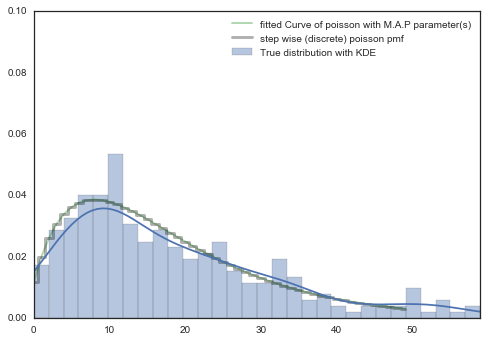

In [39]:
# Here I decided to plot the distribution
x = np.arange(0,50)
dist = scipy.stats.nbinom(mu.value,mu.value/(alpha.value+mu.value))

plt.plot(x, dist.pmf(x), color='g',
             alpha = 0.3, linewidth = 2, label = "fitted Curve of poisson with M.A.P parameter(s)")
plt.plot(x, dist.pmf(x), color = 'black', linestyle='steps-mid',alpha = 0.3,linewidth = 3,\
         label = "step wise (discrete) poisson pmf")
sns.distplot(array_like,norm_hist=  True,bins  = 30, label = "True distribution with KDE")
plt.xlim(0,max(array_like))
plt.ylim(0,0.1)
plt.legend()
plt.show

### Conclution:

After adjusting my likelihood to Negative Binomial distribution, my result fits very well. The take-away lession in this problem is that after we get large number of data points, the Prior doesn't affect the result. However, the likelihood is important, as it shows how likely you would be able to see one data given a specific model. 

It is tricky to choose a good likelihood model but we can definately to try different kinds.


# Problem 3: Markov Chains

* Given the following transition matrix, examine if the corresponding Markov Chain is irreducible and aperiodic. Note: No formal proof necessary, but you should give a solid argumentation.

$$ P = \left( 
\begin{array}{ccccc}
0.0 & 0.4 & 0.6 & 0.0 & 0.0 \\
0.65 & 0.0 & 0.35 & 0.0 & 0.0 \\
0.32 & 0.68 & 0.0 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.12 & 0.88 \\
0.0 & 0.0 & 0.0 & 0.56 & 0.44 
\end{array}
\right ) $$



The definitions of those two properties are stated as follow. 

Irreducible: Probability of reaching every state from any state is greater than zero.

Aperiodic: No "deterministic" loops.

Reducible: This transition matrix, however, doesn't satisfy the requirement for being irreducible. As the definition points out, any state should be reached through a random starting point. My hypothesis is that I could reach to state 4 from state 1. Looking at the transition matrix, I could see: 
* P(State 1 -> State4) = 0
* P(State 1  -> State2) = 0.4
* P(State2 -> State3)  = 0.35
* P(State3 -> State4)  = 0
* P(State2 -> State4) = 0

Thus, started from State 1, there is no way to reach State 4, according to this transition matrix. 

Aperiodic: The property of being aperiodic is to return to the original state at a different time. As such, a state has period of k, and if k = 1, this state is believed to be an aperiodic. Any other state linked to one aperiodic state is considered as aperiodic.

For the state 1, 1-1, 1-2-1, 1-3-1,1-2-3-1,1-2-3-2-1, the great common divisor is 1 in this case. as such, state 1, 2, 3 are all aperiodic. 

For the state 4, 4-4,4-5-4,4-5-5-4, the great common divisor is 1, as such, state 4 and 5 are all aperiodic.

Therefore, the transition matrix is an aperiodic matrix

# Problem 4: The Evidence 

In lectures we mostly concentrate on the likelihood and the prior and regard the evidence as a mere normalization factor. However, the evidence can be quite useful. In this problem you will compare different models by computing the evidence for each model, aka the probability that randomly selected parameters from a given model class would generate the data $X$.

As our models we compare polynomials of degree 0 to 4. For example for degree 2 we have $y = a_0 + a_1 \cdot x + a_2 \cdot x^2 + \epsilon$ where $\epsilon \sim N(0, \sigma) $ and $\theta = [a_0, a_1, a_2, \sigma]$. Assume that for all polynomials $a_i \sim \text{Expo}(1)$ and $\sigma \sim \text{Inverse Gamma}(1,1)$.


Bayes' theorem states that:
$$
P(\theta|x)=\frac{P(x|\theta)P(\theta)}{P(x)}
$$
$P(\theta)$ is the prior, $P(x|\theta)$ is the likelihood, $P(x)$ is called the evidence, and $P(\theta|x)$ is the posterior.

Your tasks are:

* Write down the mathematical equation of the evidence in terms of the likelihood and the prior. You don't need to solve the integral analytically, just write down its formula.
* Now you have the evidence in the form of an integral. Solve it by using importance sampling. What is a good choice for your importance sampling distribution?
* Compare the evidence for polynomials of degree 0 to 4. Which polynomial wins?

Solution:
* The formula wriiten in terms of marginal likelihood and the prior can be written as:
$$
P(\theta|x)=\frac{P(x|\theta)P(\theta)}{\int_{m}{P(x|\theta_m)P(\theta_m)}}
$$


* Here, I could just choose the prior as my important sampling distribution.Then calculate the mean value for $P(x|\theta_m)$, the answer will be the same. As you can see, if we chose to sample from prior, later on, the prior will be cancelled.

In [60]:
# Here is your data for the problem:
data = np.array([[ -1.85519254,  -2.7009541 ],
       [  4.38291824,  19.61735369],
       [  2.29495208,   3.96481822],
       [  0.02075668,   8.00646088],
       [  0.54097177,   2.8872262 ]])

x=data[:,0]
y=data[:,1]

Important Sampling estimate =  -20.7825473929
Monte Carlo Standard Deviation 0.34649421845


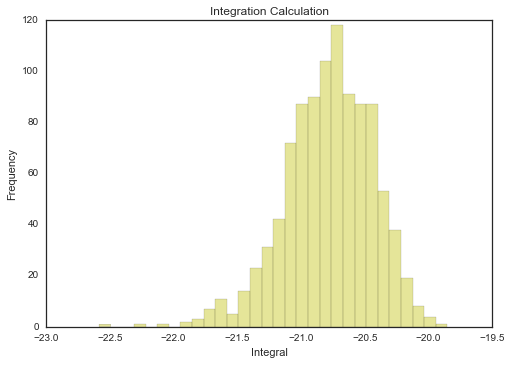

In [62]:
from scipy.stats import invgamma
from scipy.stats import norm
N = 1000
#Here is my degree 0
estimates_0 = np.zeros(N)
for num in range(N):
    #do this experiment 
    #here is my first degree
    res = np.zeros(100)
    for index in range(100):
        a = np.random.exponential(size = 1)
        sigma = invgamma.rvs(1, size=1)
        #calculate y value
        y_calculated = a
        #draw normal distribution
        prob = norm.pdf(y,loc=y_calculated,scale=sigma)
        res[index] = np.prod(prob)
    estimates_0[num] = np.log(np.mean(res))
#then we shall draw this distribution 
ax = sns.distplot(estimates_0,color="y",kde=False)
ax.set(xlabel='Integral', ylabel='Frequency',title='Integration Calculation')
print "Important Sampling estimate = ",np.mean(estimates_0)
print "Monte Carlo Standard Deviation",np.std(estimates_0)



Important Sampling estimate =  -19.1801167041
Monte Carlo Standard Deviation 0.502476653697


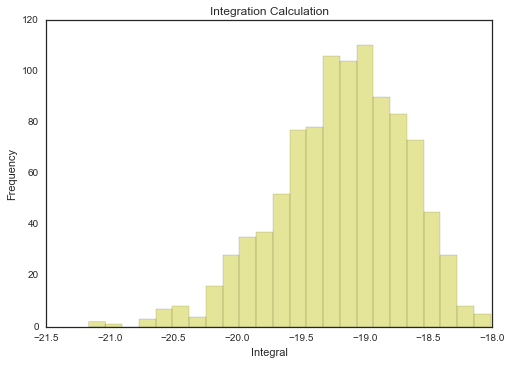

In [55]:
# Here, my important sampling will from Prior, which followed Exponential distribution
#from 0 to 4 degree, I will have 4 different ai, drawn from exponential distribution

estimates_1 = np.zeros(N)
for num in range(N):
    #do this experiment 
    #here is my first degree
    res = np.zeros(100)
    for index in range(100):
        a = np.random.exponential(size = 1)
        sigma = invgamma.rvs(1, size=1)
        #calculate y value
        y_calculated = a*x
        #draw normal distribution
        prob = norm.pdf(y,loc=y_calculated,scale=sigma)
        res[index] = np.prod(prob)
    estimates_1[num] = np.log(np.mean(res))
#then we shall draw this distribution 
ax = sns.distplot(estimates_1,color="y",kde=False)
ax.set(xlabel='Integral', ylabel='Frequency',title='Integration Calculation')
print "Important Sampling estimate = ",np.mean(estimates_1)
print "Monte Carlo Standard Deviation",np.std(estimates_1)


Important Sampling estimate =  -17.6527897851
Monte Carlo Standard Deviation 0.400819985467


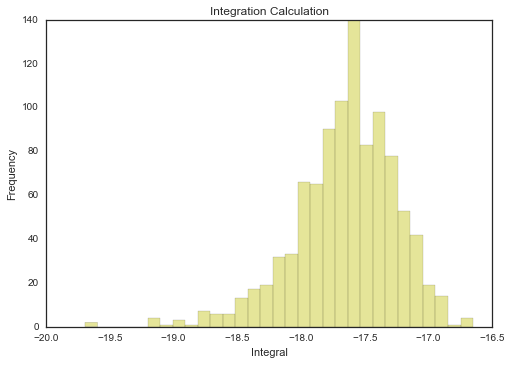

In [56]:
#This is my second degree

estimates_2 = np.zeros(N)
for num in range(N):
    res = np.zeros(100)
    y_calculated = np.zeros
    for index in range(100):
        a = np.random.exponential(size = 2)
        sigma = invgamma.rvs(1, size=1)
        #calculate y value
        y_calculated = a[0]*x + (x**2)*a[1]
        #draw normal distribution
        prob = norm.pdf(y,loc=y_calculated,scale=sigma)
        res[index] = np.prod(prob)
    estimates_2[num] = np.log(np.mean(res))
#then we shall draw this distribution 
ax = sns.distplot(estimates_2,color="y",kde=False)
ax.set(xlabel='Integral', ylabel='Frequency',title='Integration Calculation')
print "Important Sampling estimate = ",np.mean(estimates_2)
print "Monte Carlo Standard Deviation",np.std(estimates_2)

Important Sampling estimate =  -19.1237422473
Monte Carlo Standard Deviation 1.19897593451


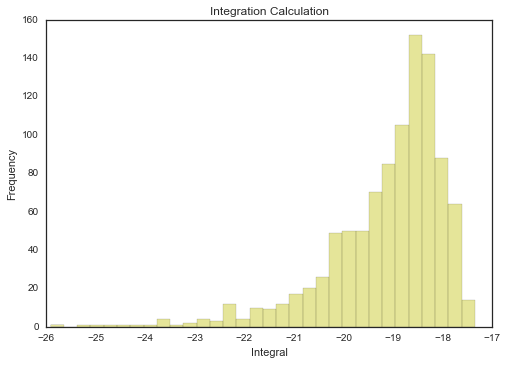

In [57]:
#This is my third degree
estimates_3 = np.zeros(N)
for num in range(N):
    res = np.zeros(100)
    y_calculated = np.zeros
    for index in range(100):
        a = np.random.exponential(size = 3)
        sigma = invgamma.rvs(1, size=1)
        #calculate y value
        y_calculated = a[0]*x + (x**2)*a[1] + (x**3)*a[2]
        #draw normal distribution
        prob = norm.pdf(y,loc=y_calculated,scale=sigma)
        res[index] = np.prod(prob)
    estimates_3[num] = np.log(np.mean(res))
#then we shall draw this distribution 
ax = sns.distplot(estimates_3,color="y",kde=False)
ax.set(xlabel='Integral', ylabel='Frequency',title='Integration Calculation')
print "Important Sampling estimate = ",np.mean(estimates_3)
print "Monte Carlo Standard Deviation",np.std(estimates_3)



Important Sampling estimate =  -32.372806529
Monte Carlo Standard Deviation 11.6177329979


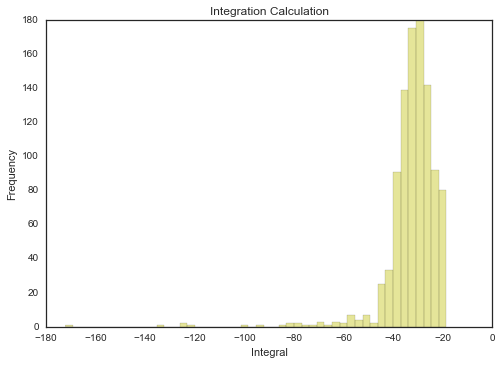

In [61]:
#This is my forth degree
estimates_4 = np.zeros(N)
for num in range(N):
    res = np.zeros(100)
    y_calculated = np.zeros
    for index in range(100):
        a = np.random.exponential(size = 4)
        sigma = invgamma.rvs(1, size=1)
        #calculate y value
        y_calculated = a[0]*x + (x**2)*a[1] + (x**3)*a[2] + (x**4)*a[3]
        #draw normal distribution
        prob = norm.pdf(y,loc=y_calculated,scale=sigma)
        res[index] = np.prod(prob)
    estimates_4[num] = np.log(np.mean(res))
#then we shall draw this distribution 
ax = sns.distplot(estimates_4,color="y",kde=False)
ax.set(xlabel='Integral', ylabel='Frequency',title='Integration Calculation')
print "Important Sampling estimate = ",np.mean(estimates_4)
print "Monte Carlo Standard Deviation",np.std(estimates_4)



### Conclusion

After carefully plotting those four plots, I could make a holistic conclusion that the second degree actually does better than other regarding about the probability. As such, the original data points have higher chance of having a quadratic term feature. 

| Degree |Probability(log)   | Std   |
|--------|-------------------|-------|
| 0      | -20.769           | 0.016 |
| 1      | -19.170           | 0.025 |
| 2      | -17.667           | 0.021 |
| 3      | -19.162           | 0.018 |
| 4      | -31.961           | 0.012 |


# Problem 5: Which YouTube Videos to Watch

Youtube videos have a like and an unlike flag. We can use these up and down votes on the videos to determine if a video is worth watching. However, it is not immediately obvious how to rank a video with just 3 up and 0 down rankings against a video with 300 up and 100 down votes. We will address this problem using a Bayesian approach.

Build two Bayesian models for the average upvote rate of a video. Both models should use the same likelihood, but different priors. Use one prior where people in general are rather undecided about videos, and one where people tend to be very opinionated. Compare the resulting posteriors for each video. How does the different choice of prior change your results? 

Given that there are so many videos on YouTube we want a really conservative way to decide if it is worth watching. Compute the 5th percentile for the posterior of each video and rank the videos according to this value. Is the 5th percentile a good indicator for the ranking? What are the benefits, what are potential drawbacks?

### The choice of Priors

In this problem, I chose Beta distribution as my Prior. As the plot below shown, the green line is undecided, which means people's choice don't have any correlation. The blue line, which alpha, beta are both 0.5, shows strong opnions. Either they like the video a lot, or they don't like the video at all.

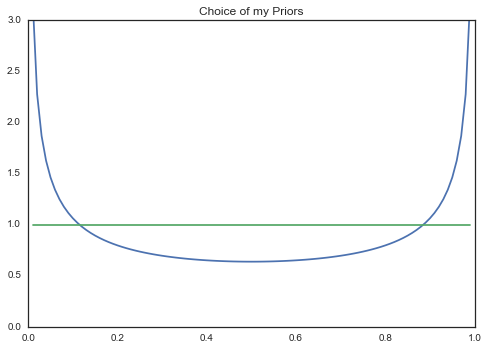

In [47]:
x = np.arange(0.01,1,0.01)
y1 = scipy.stats.beta.pdf(x,0.5,0.5)
y2 = scipy.stats.beta.pdf(x,1,1)
plt.plot(x,y1,label = "Opinionated")
plt.plot(x,y2, label = 'Undecided')
plt.title("Choice of my Priors")
plt.xlim(0,1)
plt.ylim(0,3)
plt.show()

the 5th percentile is: 0.559216056069


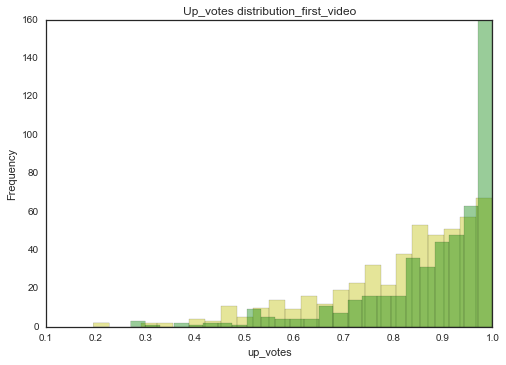

In [48]:
N = 500 #how many videos
# Here is the [upvote, downvote] data for 4 different videos:
# Data Pre-possesing 
video_votes = np.array([[3.0,0],[300.0,100],[2.0,2],[200.0,100]])
video_up = video_votes[:,0]
video_down = video_votes[:,1]
# The prior is beta distribution
# The likelihood is Bernouli
p_b =  np.mean(video_up/(video_down+video_up))
data = stats.bernoulli.rvs(p_b,size=N)#Here is my likelihood data
# Posterior data
betaUndecided = [1,1]
betaOpinioned = [0.5,0.5]
postUndecided = np.random.beta(betaUndecided[0]+video_up[0],betaUndecided[1]+video_down[0],N)
postOpiinoned = np.random.beta(betaOpinioned[0]+video_up[0],betaOpinioned[1]+video_down[0],N)
percentile = np.percentile(postOpiinoned, 5)
print "the 5th percentile is:",percentile
ax = sns.distplot(postUndecided,color='y', bins=25, kde=False,)
sns.distplot(postOpiinoned,color='g', bins=25, kde=False,)
ax
ax.set(xlabel='up_votes', ylabel='Frequency',title='Up_votes distribution_first_video')

#### Analysis:

* For the first video, since I only have very few data points available, the graph was shifted by my prior a lot. In this graph, green color represents those people who are opinioned while yellow are those who are very undecided. 
* As my prior is a straight line, so, everything depends on my data.
* The 5th Percentile for green color(as being conservative) is 0.24, which means the lowest 5% people probabilities of giving up-votes are 0.24

the 5th percentile is: 0.710495613805


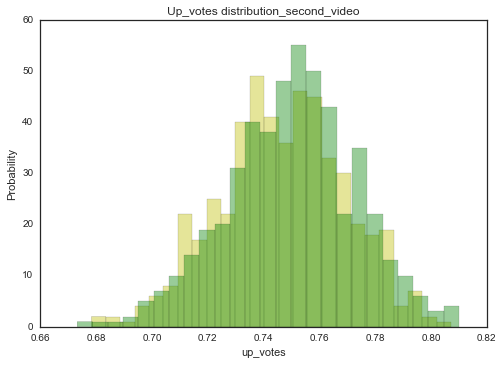

In [49]:
#second video
postUndecided = np.random.beta(betaUndecided[0]+video_up[1],betaUndecided[1]+video_down[1],N)
postOpiinoned = np.random.beta(betaOpinioned[0]+video_up[1],betaOpinioned[1]+video_down[1],N)
percentile = np.percentile(postOpiinoned, 5)
print "the 5th percentile is:",percentile
ax = sns.distplot(postUndecided,color='y', bins=25, kde=False,)
sns.distplot(postOpiinoned,color='g', bins=25, kde=False,)
ax.set(xlabel='up_votes', ylabel='Probability',title='Up_votes distribution_second_video')

#### Analysis:

Looking at this graph, we see that two graph overlapped a large portion, due to the amount of data points collected. The effects of priors are very little. The 5th percentile of the green part is 0.69, implying that probabilities of the lowest portion of people having up-voting is 0.69.

the 5th percentile is: 0.164077323943


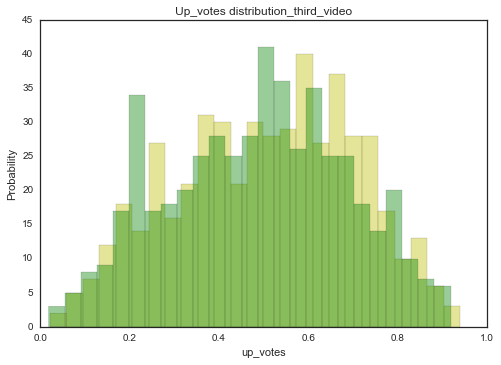

In [50]:
#third video
postUndecided = np.random.beta(betaUndecided[0]+video_up[2],betaUndecided[1]+video_down[2],N)
postOpiinoned = np.random.beta(betaOpinioned[0]+video_up[2],betaOpinioned[1]+video_down[2],N)
percentile = np.percentile(postOpiinoned, 5)
print "the 5th percentile is:",percentile
ax = sns.distplot(postUndecided,color='y', bins=25, kde=False,)
sns.distplot(postOpiinoned,color='g', bins=25, kde=False,)
ax.set(xlabel='up_votes', ylabel='Probability',title='Up_votes distribution_third_video')

#### Analysis:

Looking at this graph, we see that two graph were shifted by Priors, due to the amount of data points collected. The priors are influential. The 5th percentile of the green part is 0.17, implying that probabilities of the lowest 5% portion of people having up-voting is pretty low.

the 5th percentile is: 0.62502918873


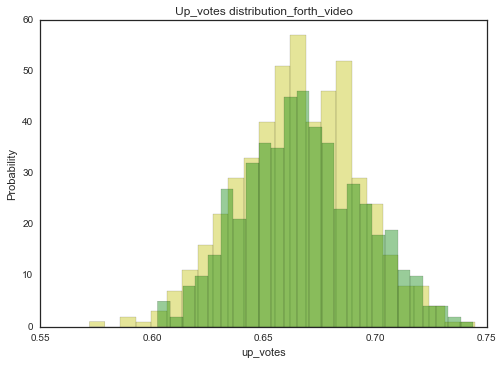

In [51]:
#forth video
postUndecided = np.random.beta(betaUndecided[0]+video_up[3],betaUndecided[1]+video_down[3],N)
postOpiinoned = np.random.beta(betaOpinioned[0]+video_up[3],betaOpinioned[1]+video_down[3],N)
percentile = np.percentile(postOpiinoned, 5)
print "the 5th percentile is:",percentile
ax = sns.distplot(postUndecided,color='y', bins=25, kde=False,)
sns.distplot(postOpiinoned,color='g', bins=25, kde=False,)
ax.set(xlabel='up_votes', ylabel='Probability',title='Up_votes distribution_forth_video')

#### Table -- Rankings of those four videos

| Video | 5th Percentile | Ranking |
|-------|----------------|---------|
| 1     | 0.26           | 3       |
| 2     | 0.69           | 1       |
| 3     | 0.17           | 4       |
| 4     | 0.60           | 2       |

#### Analysis:

Looking at this graph, we see that two graph overlapped a large portion, due to the amount of data points collected. The effects of priors are very little. The 5th percentile of the green part is 0.6, implying that probabilities of the lowest portion of people having up-voting is 0.6.

### Conclusions:

Having already discussed in great details about the results(benefits and pitfalls) associated with each video, I can now make a holistic judgement.

* To use 5th percentile is acceptable when we want to be conservative and it works very well when there are many data points collected. 

* 5th percentile is affected by prior. Since Priors are just hypothesis made from general intuition, the 5th percentile will be affected by Prior too much. If there is little points collected, I would actually choose maybe 50th percentile.